# Logic Gate Task

This task utilizes a simple neural network containing single n-task context layer to learn eight different logic gates.

In [1]:
# Import Tensorflow and Keras layers
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

import math
import numpy as np
import random

# Import n-task library
from ntask.atr   import AtrMovingAverage
from ntask.layer import Context
from ntask.model import NTaskModel

## Dataset

In [14]:
gates = ["xor", "xnor", "and", "or", "nor", "nand", "custom_1", "custom_2"]

In [15]:
labels = np.array([
    [0, 1, 1, 0], # XOR
    [1, 0, 0, 1], # XNOR
    [0, 0, 0, 1], # AND
    [0, 1, 1, 1], # OR
    [1, 0, 0, 0], # NOR
    [1, 1, 1, 0], # NAND
    [1, 0, 1, 0], # Custom 1
    [0, 1, 0, 1]  # Custom 2
])

x_train = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])

## Training and Validation

Some functions to conveniently train the model by shuffling the datasets and test the results.

In [4]:
def train(model, inputs, labels, cycles, epochs, shuffle=True, show_progress=False, batch_size=None, verbose=0):
    last_index = None
    indices = list(range(len(labels)))
    
    for cycle in range(cycles):
        
        # If the previous task is repeated, swap with a random task
        if last_index == indices[0]:
            i = randrange(1, len(indices))
            indices[0], indices[i] = indices[i], indices[0]
        
        # Train on each batch in the dataset
        for i in indices:
            print(i)
            model.fit(inputs, labels[i], epochs, progress=show_progress, batch_size=batch_size, verbose=verbose)
            assert i == model.layers[model.context_layers[0]].get_hot_context()
        
        # Shuffle at the end to preserver dataset order
        if shuffle:
            list_index = indices[-1]

            # Shuffle the dataset
            random.shuffle(indices)

In [5]:
def validate(model, inputs, labels, num_task_contexts):
    num_passed = 0
    for i in range(num_task_contexts):
        model.layers[model.context_layers[0]].set_hot_context(i)
        result = model(inputs)
        predicted = np.round(result).astype(int).flatten()
        try:
            print(f"Task {i}:", end=' ')
            assert (predicted == labels[i]).all(), "Failed on task:"
            print(result, "Passed")
            num_passed += 1
        except AssertionError:
            print(result, "Failed")
    print(f"{num_passed}/{num_task_contexts} ({100*num_passed//num_task_contexts}%) Learned successfully")

### Loss Function

In [6]:
def loss_fn(labels, predictions):
    return tf.keras.losses.binary_crossentropy(y_true=labels, y_pred=predictions)

### Optimizer

In [7]:
optimizer = tf.keras.optimizers.Adam(1e-4)

___

## Static n-task - 2 Gates (XOR, XNOR) [PASSING]

In [18]:
y_train = labels[:2]
num_task_contexts = len(y_train)

In [19]:
random.seed(5)
tf.random.set_seed(5)

### Model

In [20]:
inp = Input((2,))
x = Dense(40, activation="relu")(inp)
x = Context(AtrMovingAverage(num_task_contexts, task_switch_threshold=-0.02))(x)
x = Dense(1, activation="sigmoid")(x)

In [21]:
model = NTaskModel(inputs=inp, outputs=x, loss_fn=loss_fn, optimizer=optimizer)

### Training

In [22]:
train(model, x_train, y_train, 3, 500, batch_size=1, verbose=1)

0
1
Switching... context loss: tf.Tensor(0.13021908293107037, shape=(), dtype=float64)
Task switched to: 1
0
Switching... context loss: tf.Tensor(0.16476676250702743, shape=(), dtype=float64)
Task switched to: 0
1
Switching... context loss: tf.Tensor(0.33269712542266333, shape=(), dtype=float64)
Task switched to: 1
0
Switching... context loss: tf.Tensor(0.47866800741516924, shape=(), dtype=float64)
Task switched to: 0
1
Switching... context loss: tf.Tensor(0.7216483571818342, shape=(), dtype=float64)
Task switched to: 1


### Model Validation

Assert that the model has learned all logic gates

In [24]:
validate(model, x_train, y_train, num_task_contexts)

Task 0: tf.Tensor(
[[0.02289286]
 [0.9646863 ]
 [0.924756  ]
 [0.06937394]], shape=(4, 1), dtype=float32) Passed
Task 1: tf.Tensor(
[[0.9646759 ]
 [0.02893636]
 [0.05083215]
 [0.96020806]], shape=(4, 1), dtype=float32) Passed
2/2 (100%) Learned successfully


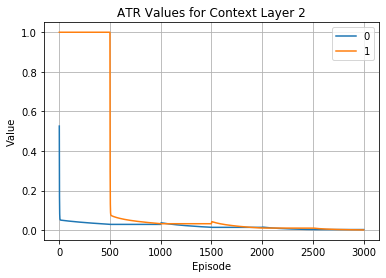

In [25]:
model.plot_atr_values()

___

## Dynamic n-task - 2 Gates (XOR, XNOR) [PASSING]

In [16]:
y_train = labels[:2]
num_task_contexts = len(y_train)

In [17]:
random.seed(5)
tf.random.set_seed(5)

### Model

In [18]:
inp = Input((2,))
x = Dense(40, activation="relu")(inp)
x = Context(AtrMovingAverage(task_switch_threshold=-0.02, is_dynamic=True, task_add_threshold=-0.1, max_num_tasks=num_task_contexts+1))(x)
x = Dense(1, activation="sigmoid")(x)

In [19]:
model = NTaskModel(inputs=inp, outputs=x, loss_fn=loss_fn, optimizer=optimizer)

### Training

In [20]:
train(model, x_train, y_train, 3, 500, batch_size=1, verbose=1)

0
1
Switching... context loss: tf.Tensor(0.13021908293107037, shape=(), dtype=float64)
Best context loss... tf.Tensor(0.13021908293107037, shape=(), dtype=float64)
Task switched (added new task): 1
0
Switching... context loss: tf.Tensor(0.16476676250702743, shape=(), dtype=float64)
Task switched to: 0
1
Switching... context loss: tf.Tensor(0.33269712542266333, shape=(), dtype=float64)
Task switched to: 1
0
Switching... context loss: tf.Tensor(0.47866800741516924, shape=(), dtype=float64)
Task switched to: 0
1
Switching... context loss: tf.Tensor(0.7216483571818342, shape=(), dtype=float64)
Task switched to: 1


### Model Validation

Assert that the model has learned all logic gates

In [22]:
validate(model, x_train, y_train, num_task_contexts)

Task 0: tf.Tensor(
[[0.02289286]
 [0.9646863 ]
 [0.924756  ]
 [0.06937394]], shape=(4, 1), dtype=float32) Passed
Task 1: tf.Tensor(
[[0.9646759 ]
 [0.02893636]
 [0.05083215]
 [0.96020806]], shape=(4, 1), dtype=float32) Passed
2/2 (100%) Learned successfully


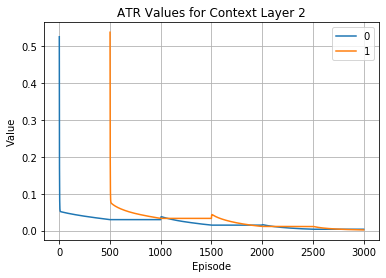

In [23]:
model.plot_atr_values()

## Static n-task - 8 Gates (XOR, XNOR, AND, OR) [PASSING]

In [31]:
y_train = labels
num_task_contexts = len(y_train)

In [32]:
random.seed(5)
tf.random.set_seed(5)

### Model

In [33]:
inp = Input((2,))
x = Dense(128, activation="relu")(inp)
x = Context(AtrMovingAverage(num_task_contexts, task_switch_threshold=-0.02))(x)
x = Dense(1, activation="sigmoid")(x)

In [34]:
model = NTaskModel(inputs=inp, outputs=x, loss_fn=loss_fn, optimizer=optimizer)

### Training

In [35]:
train(model, x_train, y_train, 3, 500, shuffle=True, show_progress=False, batch_size=1, verbose=1)

0
1
Switching... context loss: tf.Tensor(0.12544449822109366, shape=(), dtype=float64)
Task switched to: 1
2
Switching... context loss: tf.Tensor(0.04015297120993923, shape=(), dtype=float64)
Task switched to: 2
3
Switching... context loss: tf.Tensor(0.11926418838078746, shape=(), dtype=float64)
Task switched to: 3
4
Switching... context loss: tf.Tensor(0.2643416911643398, shape=(), dtype=float64)
Task switched to: 4
5
Switching... context loss: tf.Tensor(0.1614087015645926, shape=(), dtype=float64)
Task switched to: 5
6
Switching... context loss: tf.Tensor(0.09661733666669817, shape=(), dtype=float64)
Task switched to: 6
7
Switching... context loss: tf.Tensor(0.4433069906846839, shape=(), dtype=float64)
Task switched to: 7
6
Switching... context loss: tf.Tensor(0.49981857670941776, shape=(), dtype=float64)
Task switched to: 0
Switching... context loss: tf.Tensor(0.09503517341798513, shape=(), dtype=float64)
Task switched to: 1
Switching... context loss: tf.Tensor(0.3530757153673335, s

### Model Validation

Assert that the model has learned all logic gates

In [37]:
validate(model, x_train, y_train, num_task_contexts)

Task 0: tf.Tensor(
[[3.6516786e-04]
 [9.9877107e-01]
 [9.9760681e-01]
 [1.6799569e-04]], shape=(4, 1), dtype=float32) Passed
Task 1: tf.Tensor(
[[9.9828601e-01]
 [2.7096272e-04]
 [3.7968159e-04]
 [9.9950248e-01]], shape=(4, 1), dtype=float32) Passed
Task 2: tf.Tensor(
[[2.2617063e-05]
 [1.7973194e-05]
 [2.9701172e-05]
 [9.9991727e-01]], shape=(4, 1), dtype=float32) Passed
Task 3: tf.Tensor(
[[4.2262298e-05]
 [9.9998939e-01]
 [9.9991804e-01]
 [9.9999940e-01]], shape=(4, 1), dtype=float32) Passed
Task 4: tf.Tensor(
[[9.9991411e-01]
 [5.5343971e-05]
 [6.5958055e-05]
 [8.6255619e-07]], shape=(4, 1), dtype=float32) Passed
Task 5: tf.Tensor(
[[9.9995935e-01]
 [9.9998772e-01]
 [9.9995422e-01]
 [1.1062757e-05]], shape=(4, 1), dtype=float32) Passed
Task 6: tf.Tensor(
[[9.9996370e-01]
 [3.3207569e-05]
 [9.9998176e-01]
 [6.4399734e-05]], shape=(4, 1), dtype=float32) Passed
Task 7: tf.Tensor(
[[2.9828170e-05]
 [9.9979866e-01]
 [5.5688746e-05]
 [9.9989706e-01]], shape=(4, 1), dtype=float32) Passed


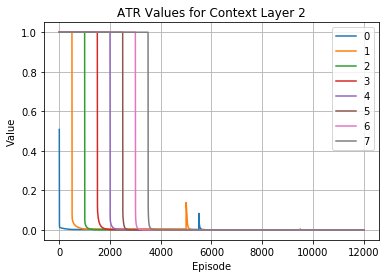

In [38]:
model.plot_atr_values()

## Dynamic n-task - 8 Gates

In [42]:
y_train = labels
num_task_contexts = len(y_train)

In [43]:
random.seed(5)
tf.random.set_seed(5)

### Model

In [44]:
inp = Input((2,))
x = Dense(256, activation="relu")(inp)
x = Context(AtrMovingAverage(is_dynamic=True, task_switch_threshold=-0.02, task_add_threshold=-0.04, max_num_tasks=num_task_contexts+1))(x)
x = Dense(1, activation="sigmoid")(x)

In [45]:
model = NTaskModel(inputs=inp, outputs=x, loss_fn=loss_fn, optimizer=optimizer)

### Training

In [46]:
train(model, x_train, y_train, 3, 750, shuffle=True, show_progress=False, batch_size=1, verbose=1)

0
1
Switching... context loss: tf.Tensor(0.12803729399554487, shape=(), dtype=float64)
Best context loss... tf.Tensor(0.12803729399554487, shape=(), dtype=float64)
Task switched (added new task): 1
2
Switching... context loss: tf.Tensor(0.0470387192921962, shape=(), dtype=float64)
Task switched to: 0
Switching... context loss: tf.Tensor(0.13979306232325495, shape=(), dtype=float64)
Best context loss... tf.Tensor(0.0470387192921962, shape=(), dtype=float64)
Task switched (added new task): 2
3
Switching... context loss: tf.Tensor(0.12245445105664006, shape=(), dtype=float64)
Task switched to: 0
Switching... context loss: tf.Tensor(0.06021763706426566, shape=(), dtype=float64)
Task switched to: 1
Switching... context loss: tf.Tensor(0.16970973015840154, shape=(), dtype=float64)
Best context loss... tf.Tensor(0.06021763706426566, shape=(), dtype=float64)
Task switched (added new task): 3
4
Switching... context loss: tf.Tensor(0.2746182329935062, shape=(), dtype=float64)
Task switched to: 0

### Model Validation

Assert that the model has learned all logic gates

In [47]:
validate(model, x_train, y_train, num_task_contexts)

Task 0: tf.Tensor(
[[2.3417779e-07]
 [9.9999881e-01]
 [9.9999952e-01]
 [3.8337971e-06]], shape=(4, 1), dtype=float32) Passed
Task 1: tf.Tensor(
[[9.9999416e-01]
 [1.1434338e-06]
 [1.1220191e-05]
 [9.9998474e-01]], shape=(4, 1), dtype=float32) Passed
Task 2: tf.Tensor(
[[1.4903513e-07]
 [6.1551469e-07]
 [5.1954984e-08]
 [9.9999988e-01]], shape=(4, 1), dtype=float32) Passed
Task 3: tf.Tensor(
[[7.204879e-07]
 [9.999927e-01]
 [9.999942e-01]
 [1.000000e+00]], shape=(4, 1), dtype=float32) Passed
Task 4: tf.Tensor(
[[9.9999958e-01]
 [4.3514154e-07]
 [1.6052305e-06]
 [1.5638378e-07]], shape=(4, 1), dtype=float32) Passed
Task 5: tf.Tensor(
[[1.0000000e+00]
 [9.9999940e-01]
 [9.9999881e-01]
 [3.9146457e-08]], shape=(4, 1), dtype=float32) Passed
Task 6: tf.Tensor(
[[9.9999988e-01]
 [3.1798587e-07]
 [9.9999952e-01]
 [2.5493891e-06]], shape=(4, 1), dtype=float32) Passed
Task 7: tf.Tensor(
[[4.4993494e-06]
 [9.9999940e-01]
 [5.3090548e-07]
 [9.9999642e-01]], shape=(4, 1), dtype=float32) Passed
8/8 

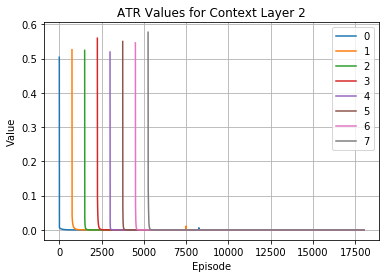

In [48]:
model.plot_atr_values()